<a href="https://colab.research.google.com/github/W-Bernau/dnMBC-Prediction-Model/blob/main/dnMBC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# De Novo Metastatic Breast Cancer Predictive Model
###### Will Bernau

# Installing Relevant Dependencies

In [ ]:
!pip install pandas==1.5.3
#Function .is_monotonic has been deprecated since this study was written, so we have to load their version of pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
!pip install scikit-survival
!pip install lifelines
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=7115afb5ba23ba34812a541ef6155daae011d6010d513838c485d1e6c71f749e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 5.0 MB/s eta 0:0

#Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sksurv.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from lifelines import utils
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

np.random.seed(12345)

# Read the data into a dataframe
##### Note: Since this is written in Colab, you'll need to make sure the notebook has access to your Google drive

Also, since the data has qualitative features, we'll have to bucket them

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SEER Model Replication/dnMBC_data.csv', sep = ",")
Sex = {'Male': 1,'Female': 0}
Vital = {'Dead': 1,'Alive': 0}

# Note: I wonder if encoding each value like this embeds a hierarchy to the model's prediction, maybe would be better to split the instances into their own featues...
Race = {'Black': 3, 'White': 2, 'Asian or Pacific Islander': 1, 'American Indian/Alaska Native': 0}
Age = {'85+ years': 14, '80-84 years': 13, '75-79 years': 12, '70-74 years': 11, '65-69 years': 10, '60-64 years': 9, '55-59 years': 8, '50-54 years': 7, '45-49 years': 6, '40-44 years': 5, '35-39 years': 4, '30-34 years': 3, "25-29 years": 2, '20-24 years': 1, '15-19 years': 0}
MaritalStatus = {'Separated': 6, 'Unmarried or Domestic Partner': 5, 'Divorced': 4, 'Single (never married)': 3, 'Married (including common law)': 2, 'Widowed': 1, 'Unknown': 0}
Grade = {'Undifferentiated; anaplastic; Grade IV': 4, 'Poorly differentiated; Grade III': 3, 'Moderately differentiated; Grade II': 2, 'Well differentiated; Grade I': 1, 'Unknown': 0}
HistBehav = {'8200/3: Adenoid cystic carcinoma': 42, '8046/3: Non-small cell carcinoma': 41, '8540/3: Paget disease, mammary': 40, '8502/3: Secretory carcinoma of breast': 39, '8315/3: Glycogen-rich carcinoma': 38, '8323/3: Mixed cell adenocarcinoma': 37, '8246/3: Neuroendocrine carcinoma, NOS': 36, '8481/3: Mucin-producing adenocarcinoma': 35, '8525/3: Polymorphous low grade adenocarcinoma': 34, '8574/3: Adenocarcinoma with neuroendocrine differentiation': 33, '8570/3: Adenocarcinoma with squamous metaplasia': 32, '8490/3: Signet ring cell carcinoma': 31, '8550/3: Acinar cell carcinoma': 30, '8260/3: Papillary adenocarcinoma, NOS': 29, '8000/3: Neoplasm, malignant': 28, '8211/3: Tubular adenocarcinoma': 27, '8575/3: Metaplastic carcinoma, NOS': 26, '8230/3: Solid carcinoma, NOS': 25, '8401/3: Apocrine adenocarcinoma': 24, '8022/3: Pleomorphic carcinoma': 23, '8513/3: Atypical medullary carcinoma': 22, '8255/3: Adenocarcinoma with mixed subtypes': 21, '8343/3: Papillary carcinoma, encapsulated': 20, '8503/3: Intraductal papillary adenocarcinoma with invasion': 19, '8501/3: Comedocarcinoma, NOS': 18, '8543/3: Paget disease and intraductal carcinoma': 17, '8504/3: Intracystic carcinoma, NOS': 16, '8521/3: Infiltrating ductular carcinoma': 15, '8510/3: Medullary carcinoma, NOS': 14, '8013/3: Large cell neuroendocrine carcinoma': 13, '8050/3: Papillary carcinoma, NOS':12, '8530/3: Inflammatory carcinoma': 11, '8524/3: Infiltrating lobular mixed with other types of carcinoma': 10, '8523/3: Infiltrating duct mixed with other types of carcinoma':9, '8541/3: Paget disease and infiltrating ductal carcinoma of breast': 8, '8201/3: Cribriform carcinoma, NOS': 7, '8140/3: Adenocarcinoma, NOS': 6, '8480/3: Mucinous adenocarcinoma':5, '8507/3: Ductal carcinoma, micropapillary': 4, '8522/3: Infiltrating duct and lobular carcinoma':3, '8520/3: Lobular carcinoma, NOS':2, '8010/3: Carcinoma, NOS':1, '8500/3: Infiltrating duct carcinoma, NOS': 0}
AJCC = {'Tis': 15,'T4NOS':13,'T1NOS': 12, 'TX': 11, 'T0': 1, 'T4b': 9, 'T4a': 8, 'T2': 6,'T3':7,  'T1mic':5, 'T4d': 10,'T4c':14, 'T1c':4, 'T1b':3, 'T1a':2, 'Blank(s)':0}
Radiation = {'None/Unknown': 0, 'Beam radiation': 1, 'Radioactive implants (includes brachytherapy) (1988+)': 2,'Radiation, NOS  method or source not specified':3,'Radioisotopes (1988+)':4,'Recommended, unknown if administered':5,'Refused (1988+)':6,'Combination of beam with implants or isotopes':7 }
Chemo = {'No/Unknown': 0, 'Yes':1}

data.Sex = [Sex[item] for item in data.Sex]
data['Race recode (W, B, AI, API)'] = [Race[item] for item in data['Race recode (W, B, AI, API)']]
data['Age recode with <1 year olds'] = [Age[item] for item in data['Age recode with <1 year olds']]
data['Marital status at diagnosis'] = [MaritalStatus[item] for item in data['Marital status at diagnosis']]
data['Grade (thru 2017)'] = [Grade[item] for item in data['Grade (thru 2017)']]
data['ICD-O-3 Hist/behav'] = [HistBehav[item] for item in data['ICD-O-3 Hist/behav']]
data['Derived AJCC T, 7th ed (2010-2015)'] = [AJCC[item] for item in data['Derived AJCC T, 7th ed (2010-2015)']]
data['Radiation recode'] = [Radiation[item] for item in data['Radiation recode']]
data['Chemotherapy recode (yes, no/unk)' ] = [Chemo[item] for item in data['Chemotherapy recode (yes, no/unk)']]
# Unnessecarily dropping Derived AJCC N, 7th ed (2010-2015) and Derived AJCC M, 7th ed (2010-2015) for now
data = data.drop(columns = ['Derived AJCC N, 7th ed (2010-2015)', 'Derived AJCC M, 7th ed (2010-2015)', 'Derived HER2 Recode (2010+)','Primary Site - labeled', 'Site recode ICD-O-3/WHO 2008','Behavior code ICD-O-3','ER Status Recode Breast Cancer (1990+)','PR Status Recode Breast Cancer (1990+)', 'Breast Subtype (2010+)'])
print(data)

       Sex  Year of diagnosis  Histologic Type ICD-O-3  Primary Site  \
0        0               2015                     8500           504   
1        0               2015                     8500           504   
2        0               2010                     8010           509   
3        0               2013                     8520           509   
4        0               2014                     8520           502   
...    ...                ...                      ...           ...   
30643    0               2013                     8500           509   
30644    0               2013                     8500           504   
30645    0               2014                     8500           509   
30646    0               2015                     8500           509   
30647    0               2015                     8010           509   

       Age recode with <1 year olds  Race recode (W, B, AI, API)  \
0                                13                            3   

# Data Preprocessing
#### Some values from the dataset need to be converted to integers, and then we need to load our data into a numpy array for lin-alg

In [ ]:
Vital = {'Dead': 1,'Alive': 0}
data = np.array(data)
print(data.shape)
datax = data[:,1:15]
datay = data[:,13:15]
print(datay)
datay[:,1] = [Vital[item] for item in datay[:,1]]

(30648, 16)
[[42 'Alive']
 [43 'Alive']
 [4 'Dead']
 ...
 [56 'Alive']
 [42 'Alive']
 [47 'Alive']]


#### Now, the data is split into the train and test sets and normalized

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size=0.2, random_state=114514)
e_train = y_train[:,1]
e_test = y_test[:,1]

X_scaler = StandardScaler().fit(x_train)
X_train = X_scaler.transform(x_train)
X_test = X_scaler.transform(x_test)

Y_scaler = StandardScaler().fit(y_train[:,0].reshape(-1, 1))
Y_train = Y_scaler.transform(y_train[:,0].reshape(-1, 1))
Y_test = Y_scaler.transform(y_test[:,0].reshape(-1, 1))

sort_idx = np.argsort(Y_train.reshape(24518))[::-1]
X_train = X_train[sort_idx]
Y_train = Y_train[sort_idx]
e_train = e_train[sort_idx]

In [ ]:
X_train.shape

(24518, 14)

# **DeepSurv**
######Under this heading will be the construction and examination of the DeepSurv model

###### First, define loss

In [ ]:
## Define the loss function for DeepSurv model
def negative_log_likelihood(E):
    def loss(y_true, y_pred):

        hazard_ratio = tf.math.exp(y_pred)
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)
        num_observed_events = tf.constant(1, dtype=tf.float32)

        neg_likelihood = neg_likelihood_ / num_observed_events

        return neg_likelihood

    return loss

# Model Construction

In [ ]:
## Define the manual DeepSurv sturcture.
activation = 'relu'
n_nodes = 64
learning_rate = 1e-3
l2_reg = 0.3
dropout = 0.3
lr_decay =  0.9

model = Sequential()
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform', input_shape=(14,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(ActivityRegularization(l2=l2_reg))

optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=learning_rate, decay=lr_decay)

model.compile(loss=negative_log_likelihood(e_train), optimizer=optimizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                960       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
callbacks = [tf.keras.callbacks.TerminateOnNaN(),
             tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/DeepSurv_SEER.h5', monitor='loss', save_best_only=True, mode='min')]

epochs = 5 #REDUCED FOR THE SAKE OF TIME ON COLAB HOSTED RUNTIME -- CHANGE BACK TO 50 IF MORE RESOURCES ARE AVAILABLE
history = model.fit(X_train, Y_train,
                    batch_size=1,
                    epochs=epochs,
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/5
24513/24518 [============================>.] - ETA: 0s - loss: 0.0018

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24518/24518 [==============================] - 70s 3ms/step - loss: 0.0018
Epoch 2/5
24518/24518 [==============================] - 67s 3ms/step - loss: -4.5133e-07
Epoch 3/5
24518/24518 [==============================] - 64s 3ms/step - loss: -1.4678e-06
Epoch 4/5
24518/24518 [==============================] - 65s 3ms/step - loss: 4.8437e-07
Epoch 5/5
24518/24518 [==============================] - 64s 3ms/step - loss: 1.4058e-07


# Define Concordance Index (C-Index)

In [ ]:
Y_pred_train = np.exp(-model.predict(X_train))
c_index_train = utils.concordance_index(Y_train, Y_pred_train, e_train)
print(f"c-index of training dataset = {c_index_train}")

Y_pred_test = np.exp(-model.predict(X_test))
c_index_test = utils.concordance_index(Y_test, Y_pred_test, e_test)
print(f"c-index of testing dataset = {c_index_test}")

767/767 [==============================] - 1s 2ms/step
c-index of training dataset = 0.40088349862821565
192/192 [==============================] - 0s 2ms/step
c-index of testing dataset = 0.406330555668448


In [ ]:
SurvY_train = Surv.from_arrays(event=e_train, time=Y_train.reshape(24518,))
SurvY_test = Surv.from_arrays(event=e_test, time=Y_test.reshape(6130,))

Y_pred_train = np.exp(model.predict(X_train))
Y_pred_test = np.exp(model.predict(X_test))


192/192 [==============================] - 1s 7ms/step


In [ ]:
concordance_index_ipcw(SurvY_train,SurvY_test,Y_pred_test.reshape(6130))

ValueError: observed time contains values smaller zero

In [ ]:
concordance_index_ipcw(SurvY_train,SurvY_train,Y_pred_train.reshape(8083))

ValueError: observed time contains values smaller zero

# Integrated Brier Score

In [ ]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter(nelson_aalen_smoothing=False)
naf.fit(Y_train, event_observed=e_train)

baseline = np.array(np.exp(-naf.cumulative_hazard_))

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


In [ ]:
baseline.shape

SurvivalP = baseline.reshape(108)
for prob in Y_pred_test.reshape(6130):
  s = baseline**prob
  SurvivalP = np.vstack([SurvivalP,s.reshape(108)])

In [ ]:
SurvY_train['time'][18:]

array([ 1.986117  ,  1.986117  ,  1.986117  , ..., -2.09099187,
       -2.09099187, -2.09099187])

In [ ]:
IBS_DeepSurv = integrated_brier_score(SurvY_train, SurvY_test, SurvivalP[1:,1:], SurvY_train['time'][18:])
print(IBS_DeepSurv)

ValueError: observed time contains values smaller zero

## 2. Cox Regression

In [ ]:
## Cox regression here didn't accept negative value in time. Denormalizeation is needed.
SurvY_train = Surv.from_arrays(event=e_train, time=y_train[:,0].reshape(24518,))
SurvY_test = Surv.from_arrays(event=e_test, time=y_test[:,0].reshape(6130,))

In [ ]:
cphNet_model = CoxnetSurvivalAnalysis(fit_baseline_model=True,l1_ratio=0.5)
cphNet_model.fit(X_train, SurvY_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True)

In [ ]:
cph_model = CoxPHSurvivalAnalysis()
cph_model.fit(X_train, SurvY_train)

CoxPHSurvivalAnalysis()

In [ ]:
lower, upper = np.percentile(SurvY_train["time"], [0, 99])
gbsg_times = np.arange(lower, upper)

In [ ]:
cphNet_surv_prob_test = np.row_stack([fn(gbsg_times) for fn in cphNet_model.predict_survival_function(X_test)])
cph_surv_prob_test = np.row_stack([fn(gbsg_times) for fn in cph_model.predict_survival_function(X_test)])

In [ ]:
cphNet_surv_prob_train = np.row_stack([fn(gbsg_times) for fn in cphNet_model.predict_survival_function(X_train)])
cph_surv_prob_train = np.row_stack([fn(gbsg_times) for fn in cph_model.predict_survival_function(X_train)])

## Cox without L1 Penalty

In [ ]:
## Training dataset
integrated_brier_score(SurvY_train, SurvY_train, cphNet_surv_prob_train, gbsg_times)

0.05264415628027875

In [ ]:
integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
IBS_CoxNet = integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
print(IBS_CoxNet)

0.03451346696535194


In [ ]:
integrated_brier_score(SurvY_train, SurvY_train, cph_surv_prob_train, gbsg_times)

0.05270896506317139

In [ ]:
integrated_brier_score(SurvY_train, SurvY_train, cphNet_surv_prob_train, gbsg_times)

0.05264415628027875

In [ ]:
integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
IBS_CoxNet = integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
print(IBS_CoxNet)

0.03451346696535194


In [ ]:
## Train dataset
cphNet_model.score(X_train, SurvY_train)

0.9268463647976197

In [ ]:
## Test dataset
cphNet_model.score(X_test, SurvY_test)
CoxNet_Cindex = cphNet_model.score(X_test, SurvY_test)
print(CoxNet_Cindex)

0.9581277306654254


In [ ]:
## Train dataset
cph_model.score(X_train, SurvY_train)

0.9267134936530217

In [ ]:
## Test dataset
cph_model.score(X_test, SurvY_test)
Cox_Cindex = cph_model.score(X_test, SurvY_test)
print(Cox_Cindex)

0.9562832814326381


#**3. DeepHit**

In [ ]:
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torch
import torchtuples as tt

# Normalizing

In [ ]:
e_train = y_train[:,1]
e_test = y_test[:,1]

X_scaler = StandardScaler().fit(x_train)
X_train = X_scaler.transform(x_train).astype('float32')
X_test = X_scaler.transform(x_test).astype('float32')

num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)

y_trainDH = labtrans.fit_transform(y_train[:,0],e_train)
y_testDH = labtrans.transform(y_test[:,0],e_test)

train = (X_train, y_trainDH)
test = (X_test, y_testDH)

# Model Building

In [ ]:
in_features = x_train.shape[1]
num_nodes = [256,512,256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

np.random.seed(1234)
_ = torch.manual_seed(123)

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

# Find optimal learning rate

0.0001

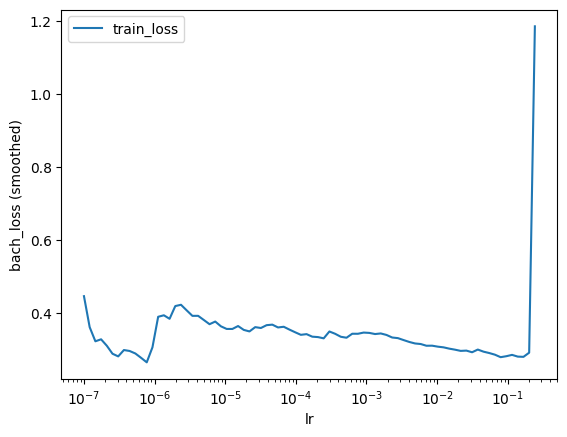

In [ ]:
## Find the optimal learning rate
batch_size = 8
lr_finder = model.lr_finder(X_train, y_trainDH, batch_size, tolerance=10)
_ = lr_finder.plot()
lr_finder.get_best_lr()

# Train the model

In [ ]:
model.optimizer.set_lr(lr_finder.get_best_lr())
epochs = 5 #REDUCED FOR THE SAKE OF TIME ON COLAB HOSTED RUNTIME -- CHANGE BACK TO 100 IF MORE RESOURCES ARE AVAILABLE
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(X_train, y_trainDH, batch_size, epochs, callbacks, val_data=test)

0:	[25s / 25s],		train_loss: 0.2166,	val_loss: 0.1256
1:	[29s / 55s],		train_loss: 0.1424,	val_loss: 0.0929
2:	[25s / 1m:20s],		train_loss: 0.1166,	val_loss: 0.0762
3:	[24s / 1m:45s],		train_loss: 0.1038,	val_loss: 0.0706
4:	[25s / 2m:10s],		train_loss: 0.0946,	val_loss: 0.0647


In [ ]:
duration_test = pd.DataFrame(y_train[:,0])
events_test = pd.DataFrame(e_train)

e = events_test[0].values
e.astype('int32')

d = duration_test[0].values
durations_test = d.astype('float32')

surv = model.predict_surv_df(X_train)

ev = EvalSurv(surv, d.astype('float32'), e.astype('int32'), censor_surv='km')
ev.concordance_td('antolini')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.9851111402397418

In [ ]:
duration_test = pd.DataFrame(y_test[:,0])
events_test = pd.DataFrame(e_test)

e = events_test[0].values
e.astype('int32')

d = duration_test[0].values
durations_test = d.astype('float32')

surv = model.predict_surv_df(X_test)
ev = EvalSurv(surv, d.astype('float32'), e.astype('int32'), censor_surv='km')
ev.concordance_td('antolini')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.9853929129287559

# Integrated brier score

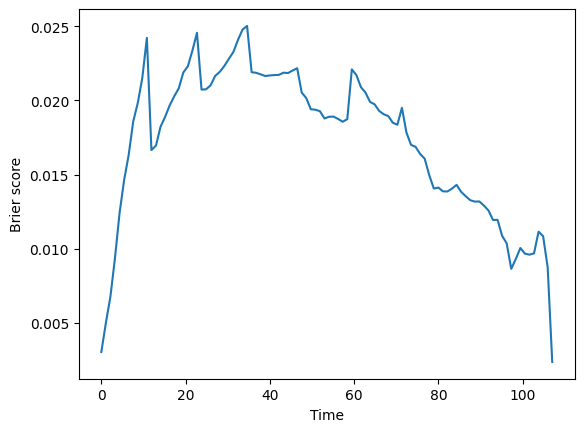

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

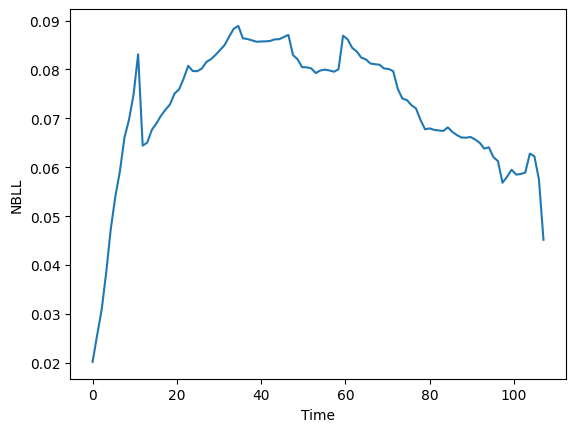

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid)

0.017393325013493166

# ComponentWise Gradient Boosting

In [ ]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
estimator = ComponentwiseGradientBoostingSurvivalAnalysis(loss="coxph").fit(X_train, SurvY_train)

In [ ]:
estimator.score(X_train, SurvY_train)

0.9907293500980544

In [ ]:
estimator.score(X_test, SurvY_test)

0.9947250694544024

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_test)])
integrated_brier_score(SurvY_train, SurvY_test, sf_test, gbsg_times)

0.052275439013653925

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_train)])
integrated_brier_score(SurvY_train, SurvY_train, sf_test, gbsg_times)

0.056119643392273176

# RandomSurvivalForest

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
estimator = RandomSurvivalForest().fit(X_train, SurvY_train)

In [ ]:
chf_train = estimator.predict_cumulative_hazard_function(X_train)
chf_test = estimator.predict_cumulative_hazard_function(X_test)

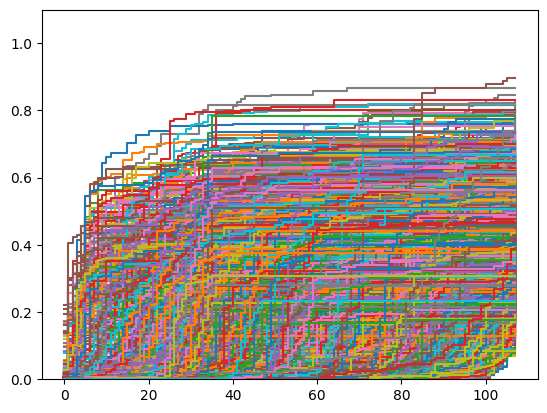

In [ ]:
for fn in chf_test:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1.1)
plt.show()

In [ ]:
sv_train = estimator.predict_survival_function(X_train)
sv_test = estimator.predict_survival_function(X_test)

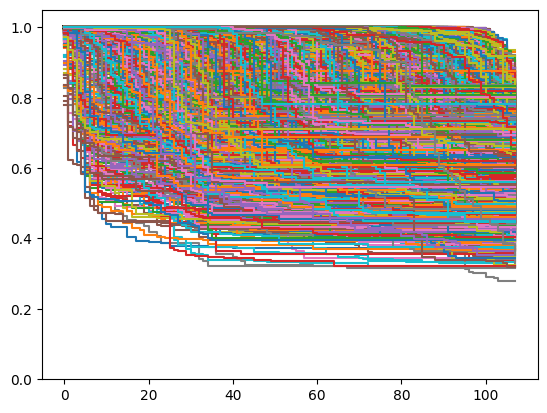

In [ ]:
for fn in sv_test:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1.05)
plt.show()

In [ ]:
estimator.score(X_train, SurvY_train)

0.9785236184170009

In [ ]:
estimator.score(X_test, SurvY_test)

0.9353913665155271

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_test)])
integrated_brier_score(SurvY_train, SurvY_test, sf_test, gbsg_times)

0.0564349297770107

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_train)])
integrated_brier_score(SurvY_train, SurvY_train, sf_test, gbsg_times)

0.03190961437358102

# FastSurvivalSVM

In [ ]:
from sksurv.svm import FastSurvivalSVM
estimator = FastSurvivalSVM().fit(X_train, SurvY_train)

ValueError: observed time contains values smaller or equal to zero

In [ ]:
## Train dataset
estimator.score(X_train, SurvY_train)

0.8870083014316208

In [ ]:
## Test dataset
estimator.score(X_test, SurvY_test)